In [1]:
import numpy as np
from astropy.table import Table, Column, join
from astropy.coordinates import SkyCoord
from astropy.table import Column
from numpy import *
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.wcs import WCS
from astropy.io import fits
from matplotlib.colors import LogNorm
from astropy.utils.data import download_file
import warnings
import os
import pandas as pd
from astropy.io import ascii

warnings.filterwarnings('ignore')

homedir = os.getenv("HOME")
catalog_path='/home/evan-barkus/Downloads/disperse_example/'

## Tables

In [2]:
# VFS SG Coords
myTab = ascii.read('/home/evan-barkus/Downloads/vfs_ascii_SG (1)(1)')

# VFS RA-DEC Coords
myTab2 = ascii.read('/home/evan-barkus/Downloads/vfs_ascii(1)')

In [3]:
# Filaments and Critical Points
data = pd.read_csv(catalog_path+'filaments_spines_3D.csv')
data2 = pd.read_csv(catalog_path+'critical_points.csv')

In [4]:
# VFS main catalog
maintab = Table.read('/home/evan-barkus/Downloads/vf_v2_main.fits')

In [5]:
len(maintab)

6780

In [6]:
# VFS environment catalog
envtab = Table.read('/home/evan-barkus/Downloads/vf_v2_environment.fits')

## Identifying the Virgo Cluster Center

In [7]:
virgo_cluster_center = max(data2['dens'])

In [8]:
# Finds which critical point corresponds to the center of the Virgo Cluster
dens = data2['dens']
for i in range(len(data2['dens'])):
    if dens[i] == virgo_cluster_center:
        print(i)

12


In [9]:
# Virgo Cluster Center Ra Dec and Z
ra2 = 188.08220312
dec2 = 12.37616886
z2 = 15.94327248*74/(3*10**5)

In [10]:
# Virgo cluster center SG coords
d = 15.943272478 #Mpc/h
sgl = np.radians(103)
sgb = np.radians(-2)

# Virgo cluster center converted to SGX, SGY, and SGX in Mpc/h
px2 = -2.080420 #d*np.sin(sgl)*np.cos(sgb)
py2 = 9.332260 #d*np.sin(sgl)*np.sin(sgb)
pz2 = -0.407146 #d*cos(sgl)

## Filament Cuts

In [11]:
# Cuts all filaments less than 3 Mpc/h long
fil_len = data['fil_len']
cut = (fil_len >= 3.0)
cutdata = data[cut]

In [12]:
# Number of unique filament spines
len(pd.unique(data['fils_number']))

80

## Identifying Cluster Members

In [13]:
# Filament Spine Coords
x_fil = np.array(data['x'])
y_fil = np.array(data['y'])
z_fil = np.array(data['z'])

# Galaxy Coords
x_gal = np.array(myTab['px'])
y_gal = np.array(myTab['py'])
z_gal = np.array(myTab['pz'])

# Critical Point Coords
x_crit = np.array(data2['x'])
y_crit = np.array(data2['y'])
z_crit = np.array(data2['z'])

In [14]:
# Finds cluster member's coords, distances from filaments, and indices

ids = myTab['id']

crit_x_gal = []
crit_y_gal = []
crit_z_gal = []
crit_dists_gal = []
crit_id = []
for i in range(len(myTab)):
    gal_id = ids[i]
    crit_dist = sqrt((px2 - x_gal[i])**2 + (py2 - y_gal[i])**2 + (pz2 - z_gal[i])**2) # 3D distance from critical point in Mpc/h
    if (crit_dist <= 3.6): # A galaxy is a cluster member if it is with 3.6 Mpc/h of the Virgo cluster center
        crit_x_gal.append(x_gal[i]) # SGX
        crit_y_gal.append(y_gal[i]) # SGY
        crit_z_gal.append(z_gal[i]) # SGZ
        crit_dists_gal.append(crit_dist)
        crit_id.append(gal_id) # indices

In [15]:
len(crit_id)

456

In [16]:
# Index numbers corresponding to galaxies that are cluster members
crit_unique = pd.unique(crit_id)

In [17]:
crit_ra = []
crit_dec = []
realid = myTab2['id']
ra = myTab2['ra']
dec = myTab2['dec']

# Finds the RA and DEC of the galaxies that were found to be cluster members in SG coords
for i in crit_unique:
    for j in realid:
        if int(i) == int(j):
            crit_ra.append(ra[int(i)])
            crit_dec.append(dec[int(i)])

## Identifying Filament Members

In [18]:
# Filament and Cluster Members Coords, Distances from Filaments, and indices
ids = myTab['id'] # index corresponding to a specific galaxy

fil_crit_id = []
fil_crit_x_gal = []
fil_crit_y_gal = []
fil_crit_z_gal = []
fil_crit_dists_gal = []
for i in range(len(myTab)):
    for j in range(len(data)):
        gal_id2 = ids[i]
        fil_dist = sqrt((x_fil[j] - x_gal[i])**2 + (y_fil[j] - y_gal[i])**2 + (z_fil[j] - z_gal[i])**2) # 3D distance from filament spines in Mpc/h
        if (fil_dist <= 2): # Limits to galaxies within 2Mpc/h of a spine
            fil_crit_x_gal.append(x_gal[i])
            fil_crit_y_gal.append(y_gal[i])
            fil_crit_z_gal.append(z_gal[i])
            fil_crit_dists_gal.append(fil_dist)
            fil_crit_id.append(gal_id2)

In [19]:
# Removes duplicate galaxies from the previous code blocks
fil_crit_x = pd.unique(fil_crit_x_gal) 
fil_crit_y = pd.unique(fil_crit_y_gal)
crit_x = pd.unique(crit_x_gal)
crit_y = pd.unique(crit_y_gal)

# Removes cluster members from the fil_crit arrays made above to produce just the locations of filament members
fx = [i for i in fil_crit_x if i not in crit_x] # SGX of filament galaxies
fy = [i for i in fil_crit_y if i not in crit_y] # SGY of filament galaxies

In [20]:
# Index numbers corresponding to galaxies that are both filament and cluster members
fc_unique = pd.unique(fil_crit_id) # removes any repeat galaxies

In [21]:
realid = myTab2['id']
ra = myTab2['ra']
dec = myTab2['dec']

# Finds the RA and DEC of the galaxies that were found to be both filament and cluster members in SG coords
fil_crit_ra = []
fil_crit_dec = []
for i in fc_unique:
    for j in realid:
        if int(i) == int(j):
            fil_crit_ra.append(ra[int(i)])
            fil_crit_dec.append(dec[int(i)])

In [22]:
# Number of cluster members
len(crit_ra)

456

In [23]:
# Number of total filament, group, and cluster members
len(fil_crit_ra)

4049

## Identifying Group Members

In [24]:
# VFS RA-DEC Coords
myTab3 = Table.read('/home/evan-barkus/Downloads/vf_v2_kourkchi_galaxies.fits')

In [25]:
min(myTab3['Mem'])

1

In [26]:
len(myTab3)

6780

In [27]:
# cut all galaxies with Mem = 1 (not in a group)
memcut = (myTab3['Mem'] != 1)
memTab = myTab3[memcut]

In [28]:
# Need to match up ra and dec coords because they are rounded to 4 decimal places in kourkchi
RA = maintab['RA']
DEC = maintab['DEC']

Group_VFID = memTab['VFID']
Main_VFID = maintab['VFID']

group_ra = []
group_dec = []

for i in range(len(Main_VFID)):
    for j in range(len(Group_VFID)):
        if Main_VFID[i] == Group_VFID[j]:
            group_ra.append(RA[i])
            group_dec.append(DEC[i])

In [29]:
# Remove duplicates
group_ra2 = pd.unique(group_ra)
group_dec2 = pd.unique(group_dec)

In [30]:
# number of group members
len(group_dec2)

3677

In [31]:
len(group_ra2)

3677

In [32]:
# Removes group members from the fil_crit arrays made above to produce just the locations of filament members
fil_group_ra = [i for i in fil_crit_ra if i not in crit_ra] # RA of filament and group galaxies
fil_group_dec = [i for i in fil_crit_dec if i not in crit_dec] # DEC of filament and group galaxies
fil_ra = [i for i in fil_group_ra if i not in group_ra2] # RA of filament galaxies
fil_dec = [i for i in fil_group_dec if i not in group_dec2] # DEC of filament galaxies

In [33]:
len(fil_dec)

1359

In [34]:
len(fil_ra)

1360

## Identifying Field Galaxies

In [35]:
field_ra = [i for i in RA if i not in fil_crit_ra]
field_dec = [i for i in DEC if i not in fil_crit_dec]

In [36]:
len(field_ra)

2731

## Ratios

In [37]:
# Group members are expected to be about half of the galaxies in the sample
len(group_ra)/len(maintab)

0.542330383480826

In [38]:
# Filament members should be around 
len(fil_ra)/len(maintab)

0.20058997050147492

In [39]:
# Cluster members are expected to be 
len(crit_ra)/len(crit_dec)

1.0

## Plots

Text(0.5, 1.0, 'VFS Filaments and Clusters')

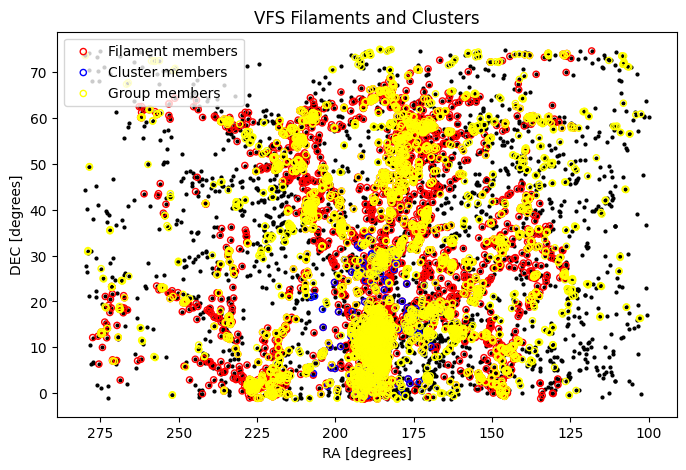

In [40]:
# Plots VFS galaxies with circles representing the filament and cluster members
vpoints = maintab['vr'] # Recessional Velocity
plt.figure(figsize=(8, 5))
plt.scatter(maintab['RA'],maintab['DEC'],s=4,color='black') # Plot VFS RA and DEC (c=vpoints,cmap='viridis',)
plt.scatter(fil_crit_ra,fil_crit_dec,color='red',marker='o',facecolors='none',s=20, label='Filament members') # Plot cluster members
plt.scatter(crit_ra,crit_dec,color='blue',marker='o',facecolors='none',s=20, label='Cluster members') # Plot filament members
plt.scatter(group_ra,group_dec,color='yellow',marker='o',facecolors='none',s=20,label='Group members') # Plot group members
plt.xlim(reversed(plt.xlim()))
plt.legend()
plt.xlabel('RA [degrees]')
plt.ylabel('DEC [degrees]')
plt.title('VFS Filaments and Clusters')

#cbar = plt.colorbar()
#cbar.set_label('$v_r$ [km/s]',rotation=270,labelpad=20)

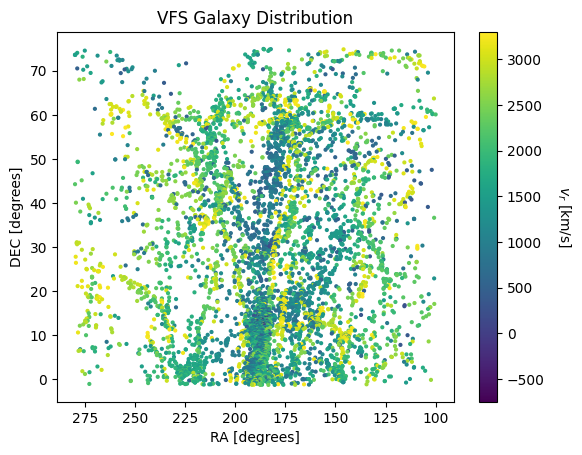

In [41]:
vpoints = maintab['vr'] # Recessional Velocity

plt.scatter(maintab['RA'],maintab['DEC'],c=vpoints,cmap='viridis',s=4) # Plot VFS RA and DEC
plt.title('VFS Galaxy Distribution')
plt.xlabel('RA [degrees]')
plt.ylabel('DEC [degrees]')
plt.xlim(reversed(plt.xlim()))
cbar = plt.colorbar()
cbar.set_label('$v_r$ [km/s]',rotation=270,labelpad=20)

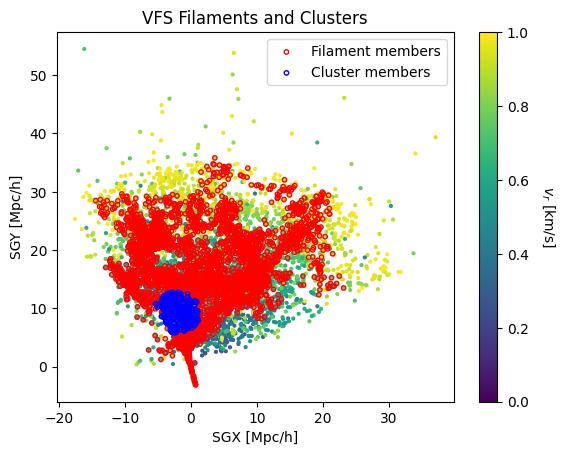

In [42]:
# The same filament and cluster members plotted in SGX and SGY
vpoints = maintab['vr'] # Recessional Velocity

plt.scatter(envtab['SGX'],envtab['SGY'],c=vpoints,cmap='viridis',s=4) # Plot VFS RA and DEC
plt.scatter(fx,fy,color='red',marker='o',facecolors='none',s=10, label='Filament members') # Plot filament members
plt.scatter(crit_x_gal,crit_y_gal,color='blue',marker='o',facecolors='none',s=10, label='Cluster members') # Plot cluster members
#plt.xlim(reversed(plt.xlim()))
plt.legend()
plt.xlabel('SGX [Mpc/h]')
plt.ylabel('SGY [Mpc/h]')
plt.title('VFS Filaments and Clusters')

cbar = plt.colorbar()
cbar.set_label('$v_r$ [km/s]',rotation=270,labelpad=20)